In [51]:
import fedoo as fd
import numpy as np
import pyvista as pv

c:\Users\okouo\miniconda3\envs\Fedoo_DSTI\Lib\site-packages\pyvista\jupyter\notebook.py:36: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


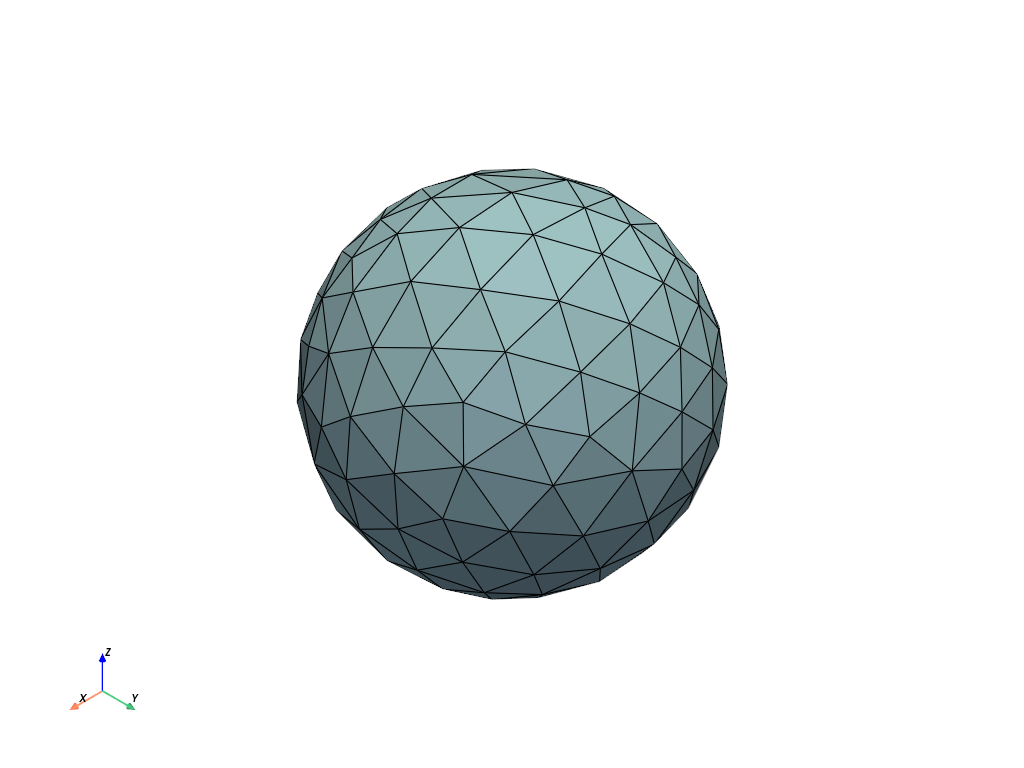

In [52]:
# 1. Espace de modélisation 3D
fd.ModelingSpace("3D")

# 2. Charger le maillage sphérique (Gmsh
mesh = pv.read("3DSphere.msh")
mesh = mesh.extract_cells_by_type(10)# Extraction des éléments de type 10 (tétraèdres = volume 3D)
mesh = fd.Mesh.from_pyvista(mesh)
mesh.plot()

In [53]:
# 3. Extraire les coordonnées des nœuds à la surface externe
surface_mesh = fd.mesh.extract_surface(mesh) # Extraire le maillage de surface
surface_nodes = np.unique(surface_mesh.elements) # Extraire les indices de nœuds à la surface

In [54]:
# 4. Définir un matériau élastique isotrope 
# Module D'Young de l'acier
material = fd.constitutivelaw.ElasticIsotrop(200000, 0.3)


In [55]:
# 5. Définir le problème de mécanique 
# méthode numérique FEM
# mathematique appliqué : construire une forme faible du problème
# assembler le tout (mesh + comportement + forme faible) => un système à résoudre KU=F
wf = fd.weakform.StressEquilibrium(material)# equilibre des efforts
assembly = fd.Assembly.create(wf, mesh)

In [ ]:
# 6. Créer le problème 
pb = fd.problem.Linear(assembly) 

In [57]:
# 7. Calculer le déplacement radial vers le centre (compaction) (Conditions aux limites)
X = mesh.nodes # Coordonnées des nœuds
r = np.linalg.norm(X[surface_nodes], axis=1)# Rayon de chaque nœud en surface
radial_dir = -X[surface_nodes] / r[:, None] # Vecteurs unitaires vers le centre
compaction = 0.05   # Facteur de compaction (5%)
u_compaction = compaction * radial_dir    # Déplacement imposé

In [58]:
print("surface_nodes shape:", surface_nodes.shape)
print("u_compaction shape:", u_compaction.shape)
print("First few entries of u_compaction:\n", u_compaction[:5])


surface_nodes shape: (164,)
u_compaction shape: (164, 3)
First few entries of u_compaction:
 [[ 3.8325962e-02 -2.9747119e-02 -1.2092563e-02]
 [-1.0044620e-02 -3.8096245e-02  3.0786067e-02]
 [-1.5996242e-02 -4.3131962e-02  1.9589640e-02]
 [-4.7562916e-02 -1.3288704e-02 -7.8217229e-03]
 [-4.7552828e-02  1.1646699e-17 -1.5450850e-02]]


In [ ]:
# 8. Appliquer les déplacements imposés sur la surface
pb.bc.add("Dirichlet", surface_nodes, "Disp", u_compaction)


results = pb.add_output(assembly, ["Disp", "Stress"])

In [60]:
# 9. resolution

pb.solve()

ValueError: shape mismatch: value array of shape (3,) could not be broadcast to indexing result of shape (164,)

In [ ]:
# 10. Affichage du champ de déplacement
results.plot("Disp")